In [1]:
import os
import pandas as pd
import numpy as np
import csv
import re

from sqlalchemy import inspect
from sqlalchemy import create_engine, MetaData, Table, text, select
from sqlalchemy.orm import sessionmaker

import time

import seaborn as sns
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.DEBUG)

### Accessing the database

In [2]:
# create engine
engine = create_engine("postgresql://adityakanthale@localhost/imdb-yin")
args, kwargs = engine.dialect.create_connect_args(engine.url)

# load metadata
metadata = MetaData()
metadata.create_all(engine)

# inspector to view columns and database
inspector = inspect(engine)

In [3]:
# load table
cast_info_tb = Table('cast_info', metadata)

#create session
Session = sessionmaker(bind=engine)
session = Session()

### Pre-processing (Generic)

Data Pre-processing:

1. Read join tables
2. Locate foreign key, sensitive attributes
1. identify continuous values
    1. bin them
    2. add these as new columns

Routine:

1. Find distribution of attributes highly-correlated with the sensitive attrs
2. Find join over samples with threshold a threshold for minority class???
3. Maximal uncovered Pattern

In [4]:
def write_table_to_csv(table_name, out_dir='./data/imdb'):

    with engine.connect() as conn:
        query = text(f"SELECT * FROM {table_name}")
        rs = conn.execute(query)
        with open(f"{out_dir}/{table_name}.csv", 'w') as f:
            outcsv = csv.writer(f)
            outcsv.writerow(rs.keys())
            outcsv.writerows(rs)

In [115]:
write_table_to_csv('ROLE_TYPE')
write_table_to_csv('MOVIE_COMPANIES')
write_table_to_csv('CAST_INFO')

In [5]:
write_table_to_csv('NAME')
write_table_to_csv('AKA_NAME')

In [5]:
def write_table_to_df(table_name):
    df = pd.DataFrame()
    with engine.connect() as conn:
        df = pd.read_sql_table(table_name=str(table_name).lower(), con=conn)
        df.head()
    return df

In [6]:
movie_companies_df = write_table_to_df('MOVIE_COMPANIES')

In [7]:
role_type_df = write_table_to_df('ROLE_TYPE')
cast_info_df = write_table_to_df('CAST_INFO')

In [9]:
aka_name = write_table_to_df('AKA_NAME')
name = write_table_to_df('NAME')

In [10]:
continent = write_table_to_df('CONTINENT')
company_name = write_table_to_df('COMPANY_NAME')

In [15]:
write_table_to_csv(continent)
write_table_to_csv(company_name)

In [11]:
"""
Pre-processing for the note column in the movie companies table

"""

def check_years(yr):
  year_pattern = r"\d{4}(?:-)?" # 2008, 2008-2012, 2008-
  return yr and re.match(year_pattern, yr)

def check_area(ar):
  area_len = 20
  area_pattern = r"^[a-zA-Z\s]+$"
  return ar and len(ar) <= area_len and re.match(area_pattern, ar)

def convert_to_valid(arr):
  res = [[], None, None]
  for idx, e in enumerate(arr):
    if check_years(e): res[0].append(e)
    else:
      if check_area(e): res[1] = e
      res[2] = ','.join(arr[idx+1:])
      break
  return res

def split_note(note):
    if note:
        note_s = note.split(') ')
        note_vals = [s.strip('(').strip(')') for s in note_s]
        note_vals = convert_to_valid(note_vals)
        return note_vals
    return [None, None, None]

split_note_df = movie_companies_df['note'].apply(split_note)
columns=['year', 'area', 'remark']
movie_companies_df[columns] = pd.DataFrame(split_note_df.to_list(), columns=columns)
movie_companies_df.head()

,id,movie_id,company_id,company_type_id,note,area_code,continent_code,year,area,remark
0,131,405,27,1,(2001) (UK) (TV),[gb],EU,[2001],UK,TV
1,132,414,39,1,(2009) (UK) (TV),[gb],EU,[2009],UK,TV
2,133,579,40,1,(2012) (worldwide) (DVD),[dk],EU,[2012],worldwide,DVD
3,134,580,40,1,(2012) (worldwide) (DVD),[dk],EU,[2012],worldwide,DVD
4,140,581,46,1,(2010) (Hungary) (TV) (re-release),[hu],EU,[2010],Hungary,"TV,re-release"


In [12]:
min_year = 1850
max_year = 2023

def get_bin_map(yr):
    """ map year to nearest decade """
    return (yr-min_year)//10

def get_bin_yr(yr):
    """ returns the binned index of the year """
    if yr:
        yr = yr[0] # taking only the first year
        if '-' in yr:
            yr = yr[:yr.index('-')]
        yr = int(yr[:4])
        return get_bin_map(yr)

In [13]:
mc_copy = movie_companies_df.copy()
mc_copy['year'] = mc_copy['year'].apply(func=get_bin_yr)
print(len(mc_copy))
print(len(mc_copy[mc_copy['year'].between(0,(max_year-min_year)//10)]))

2609129
1121494


In [16]:
mc_copy[mc_copy['year'].between(0,(max_year-min_year)//10)].to_csv('./out/movie_copmpanies_processed.csv')

In [14]:
mc = pd.read_csv('./data/imdb/movie_copmpanies_processed.csv')

## Experiments

In [15]:
mc.head()

,Unnamed: 0,id,movie_id,company_id,company_type_id,note,year,area,remark
0,0,1,2,1,1,(2006) (USA) (TV),15.0,USA,TV
1,1,2,2,1,1,(2006) (worldwide) (TV),15.0,worldwide,TV
2,2,3,11,2,1,(2012) (worldwide) (all media),16.0,worldwide,all media
3,3,4,44,3,1,(2013) (USA) (all media),16.0,USA,all media
4,4,5,50,4,1,(2011) (UK) (TV),16.0,UK,TV


In [16]:
cast_info_df.head()

,id,person_id,movie_id,person_role_id,note,nr_order,role_id
0,1,1,968504,1.0,None,NaN,1
1,2,2,2163857,1.0,None,25.0,1
2,3,2,2324528,2.0,None,22.0,1
3,4,3,1851347,NaN,None,12.0,1
4,5,4,1681365,3.0,None,NaN,1


In [40]:
aka_name.head()

,id,person_id,name,imdb_index,name_pcode_cf,name_pcode_nf,surname_pcode,md5sum
0,1,4061927,"Smith, Jessica Noel",None,S5325,J2542,S53,25c9d464e3ff2957533546aa92b397ed
1,2,4,"Short, Too",None,S63,T263,None,4e26116e5f9800cef90c8f8c38de2584
2,3,2701136,"Abdul-Hamid, Jaffar",None,A1345,J1613,None,fb5126fe9992e13156c636d726cec257
3,4,2701136,"Al-Hamid, Jaffar Abd",None,A4532,J1613,A453,179ad5f75c84c4bddd6733c66b6b0bb7
4,5,15,"Viera, Michael 'Power'",None,V6524,M2416,V6,354cea2b99f8b1f745ea6092eefa2bd7


In [41]:
name = name[name['gender'].isna()==False]
name.head()

,id,name,imdb_index,imdb_id,gender,name_pcode_cf,name_pcode_nf,surname_pcode,md5sum
0,3343,"Abela, Mike",None,None,m,A1452,M214,A14,61f733c0298a7cb5a461fd787a655d70
1,446,"A., David",None,None,m,A313,D13,A,cf45e7b42fbc800c61462988ad1156d2
2,126,"-Alverio, Esteban Rodriguez",None,None,m,A4162,E2315,A416,f5c410bff6839b545d04c531f776e8f2
3,1678,"Abbas, Athar",None,None,m,A1236,A3612,A12,cf230f6ed718a330dc688c20b8d741d3
4,3610,"Aberer, Leo",None,None,m,A164,L16,A16,05684f16b84db387e613d3de57eca5b7


#### SQL Join queries

SELECT * \
FROM aka_name \
JOIN name ON aka_name.person_id = name.id \
JOIN cast_info ON cast_info.person_id = name.id

In [42]:
# time taken = 3.8s
joined_df = pd.merge(aka_name, name, left_on='person_id', right_on='id', how='inner')

In [44]:
joined_df.columns

Index(['id_x', 'person_id', 'name_x', 'imdb_index_x', 'name_pcode_cf_x',
       'name_pcode_nf_x', 'surname_pcode_x', 'md5sum_x', 'id_y', 'name_y',
       'imdb_index_y', 'imdb_id', 'gender', 'name_pcode_cf_y',
       'name_pcode_nf_y', 'surname_pcode_y', 'md5sum_y'],
      dtype='object')

In [26]:
aka_name_join_idx = joined_df['id_x']
name_join_idx = joined_df['id_y']

In [20]:
selected_cols = ['gender', 'id_x', 'person_id']
sensitive_attr = 'gender'

In [21]:
joined_df = joined_df[selected_cols]
joined_df['gender'].value_counts()

m    385379
f    193486
Name: gender, dtype: int64

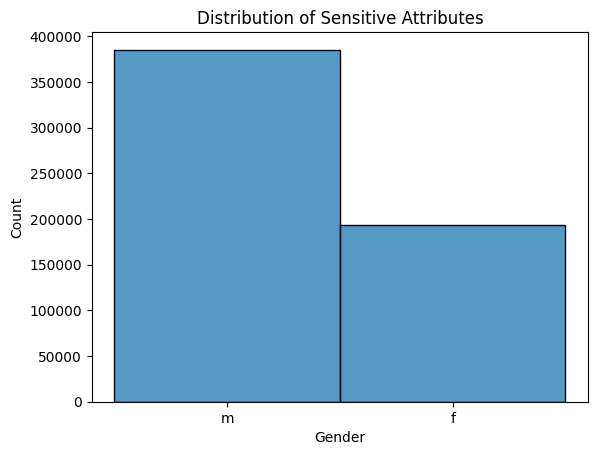

In [23]:
""" population distribution of sensitive attributes """

sns.histplot(data=joined_df, x='gender')

# Set labels for the x-axis, y-axis, and title
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of Sensitive Attributes')
plt.savefig('./out/gender_dist_actual_join.png')
plt.show()

In [50]:
aka_name_cols = ['person_id', 'id']
name_cols = ['id', 'name', 'gender']

In [60]:
def get_sampled_dfs(f):
    return (joined_df.sample(frac=f), 
    aka_name.filter(items=aka_name_cols)[aka_name['person_id'].isin(joined_df['person_id'])].sample(frac=f), 
    name.filter(items=name_cols)[name['id'].isin(joined_df['id_y'])].sample(frac=f))

In [55]:
dfs = [
    joined_df,
    name,
    aka_name
]

sampling_rates = [0.005,0.01,0.015,0.02]
for f in sampling_rates:
    sampled_dfs = get_sampled_dfs(f)
    

In [108]:
from numpy.random import binomial

seed = 42
np.random.seed(seed)


In [118]:
def stratified_sampling(df, frac, col):
    """ Samples uniformly within stratas (or groups) within column col in dataframe df"""
    groups = df.groupby(col)
    sample_sizes = (groups.size() * frac).astype(int)
    
    sampled_rows = []
    for group_name, group in groups:
        if sample_sizes[group_name] > 0:
            sampled_rows.append(group.sample(n=sample_sizes[group_name], replace=False))

    sampled_df = pd.concat(sampled_rows)
    sampled_df = sampled_df.sample(frac=1, random_state=seed)
    return sampled_df


def bernoulli_sampling(df, frac, p=0.5):
    """ Bernoulli sampling """
    mask = np.random.binomial(1, p, len(df)) == 1 
    return df[mask].sample(round(frac*len(df)), replace=False, random_state=seed) 


def uniform_sampling(df, frac):
    """ Uniform sampling """
    return df.sample(frac=frac, random_state=seed)

## Correlation-aware Sampling

Here we sample 

In [119]:
import random
import math

N = 100000007
def compute_hash(v):
    """ Computes the hash for a list-like value v """
    k = random.randint(1, math.inf)
    b = random.randint(1, math.inf)
    return (k * v + b) % N



def correlation_sampling(df, sattr, frac):
    
    return df

In [120]:
BERNOULLI = 'Bernoulli'
STRATIFIED = 'Stratified'
UNIFORM = 'Uniform'
CORRELATION_AWARE = 'Correlation'

SAMPLING_TECHNIQUES = {BERNOULLI:bernoulli_sampling, 
                        STRATIFIED:stratified_sampling, 
                        UNIFORM:uniform_sampling}#, 
                        #CORRELATION_AWARE:correlation_sampling}

In [121]:
sampling_rates = [0.005, 0.01, 0.015, 0.02]
sampled_join_dict = {}

In [127]:
"""
Compute the demographic parities of the sensitive attribute for different sampling rates
"""

for technique in SAMPLING_TECHNIQUES:
    print(f'Current sampling technique: {technique}')
    join_dict = {}
    for frac in sampling_rates:
        if technique in [BERNOULLI, UNIFORM]:
            sname = SAMPLING_TECHNIQUES[technique](name, frac)
            sakaname = SAMPLING_TECHNIQUES[technique](aka_name, frac)
            sjoin = pd.merge(sakaname, sname, left_on='person_id', right_on='id', how='inner')
        join_dict[frac] = sjoin['gender'].value_counts().to_dict()
        print(f'     Sampling rate: {frac} DONE')
    sampled_join_dict[technique] = join_dict
print(sampled_join_dict)

Current sampling technique: Bernoulli
     Sampling rate: 0.005 DONE
     Sampling rate: 0.01 DONE
     Sampling rate: 0.015 DONE
     Sampling rate: 0.02 DONE
Current sampling technique: Stratified
     Sampling rate: 0.005 DONE
     Sampling rate: 0.01 DONE
     Sampling rate: 0.015 DONE
     Sampling rate: 0.02 DONE
Current sampling technique: Uniform
     Sampling rate: 0.005 DONE
     Sampling rate: 0.01 DONE
     Sampling rate: 0.015 DONE
     Sampling rate: 0.02 DONE
{'Bernoulli': {0.005: {'m': 13, 'f': 10}, 0.01: {'m': 47, 'f': 17}, 0.015: {'m': 96, 'f': 58}, 0.02: {'m': 153, 'f': 85}}, 'Stratified': {0.005: {'m': 153, 'f': 85}, 0.01: {'m': 153, 'f': 85}, 0.015: {'m': 153, 'f': 85}, 0.02: {'m': 153, 'f': 85}}, 'Uniform': {0.005: {'m': 13, 'f': 5}, 0.01: {'m': 39, 'f': 23}, 0.015: {'m': 85, 'f': 48}, 0.02: {'m': 149, 'f': 86}}}


In [128]:
def normalize_dicts(d):
    d_norm = {}
    for k, vdicts in d.items():
        total = sum(vdicts.values())
        temp = {}
        for key, _ in vdicts.items():
            temp[key] = (vdicts[key]/total)*1000
        d_norm[k] = temp
    return d_norm


sampled_join_dict_norm = {}
for k,v in sampled_join_dict.items():
    sampled_join_dict_norm[k] = normalize_dicts(v)

print(sampled_join_dict)
print(sampled_join_dict_norm)

{'Bernoulli': {0.005: {'m': 13, 'f': 10}, 0.01: {'m': 47, 'f': 17}, 0.015: {'m': 96, 'f': 58}, 0.02: {'m': 153, 'f': 85}}, 'Stratified': {0.005: {'m': 153, 'f': 85}, 0.01: {'m': 153, 'f': 85}, 0.015: {'m': 153, 'f': 85}, 0.02: {'m': 153, 'f': 85}}, 'Uniform': {0.005: {'m': 13, 'f': 5}, 0.01: {'m': 39, 'f': 23}, 0.015: {'m': 85, 'f': 48}, 0.02: {'m': 149, 'f': 86}}}
{'Bernoulli': {0.005: {'m': 565.2173913043478, 'f': 434.7826086956522}, 0.01: {'m': 734.375, 'f': 265.625}, 0.015: {'m': 623.3766233766233, 'f': 376.62337662337666}, 0.02: {'m': 642.8571428571429, 'f': 357.14285714285717}}, 'Stratified': {0.005: {'m': 642.8571428571429, 'f': 357.14285714285717}, 0.01: {'m': 642.8571428571429, 'f': 357.14285714285717}, 0.015: {'m': 642.8571428571429, 'f': 357.14285714285717}, 0.02: {'m': 642.8571428571429, 'f': 357.14285714285717}}, 'Uniform': {0.005: {'m': 722.2222222222222, 'f': 277.77777777777777}, 0.01: {'m': 629.0322580645161, 'f': 370.9677419354839}, 0.015: {'m': 639.0977443609023, 'f':

In [129]:
total_join = len(joined_df)
join_dict = joined_df['gender'].value_counts()
join_dict_norm = {}
for k,v in join_dict.items():
    join_dict_norm[k] = (join_dict[k]/total_join)*1000
print(join_dict_norm)

{'m': 665.7493543399584, 'f': 334.25064566004164}


In [133]:
def save_parity_plot(expjoin, smpljoin, technique):
    fig, axs = plt.subplots()
    sns.scatterplot(x=smpljoin.keys(), y=[d['m'] for d in smpljoin.values()], linestyle='--', marker='o', label="'m' in sampled join")
    sns.scatterplot(x=smpljoin.keys(), y=[d['f'] for d in smpljoin.values()], linestyle='--', marker='o', label="'f' in sampled join")
    plt.axhline(y=expjoin['m'], color="b", linestyle="--", label="'m' in explicit join")
    plt.axhline(y=expjoin['f'], color="r", linestyle="--", label="'f' in explicit join")
    plt.xlabel('Sampling rate %')
    plt.ylabel('Group Parity x 10^3')
    plt.title(f'{technique} Sampling', loc='center')
    plt.legend()
    # sns.scatterplot(data=sampled_join_dict, linestyle='--', marker='o')
    # sns.scatterplot(data=, linestyle='--', marker='o')
    plt.savefig(f'./out/{technique.lower()}_sampling_parity.png')

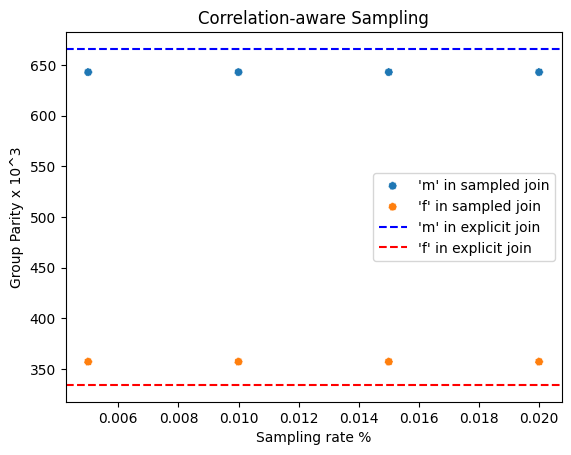

In [135]:
save_parity_plot(join_dict_norm, sampled_join_dict_norm[STRATIFIED], "Correlation-aware")

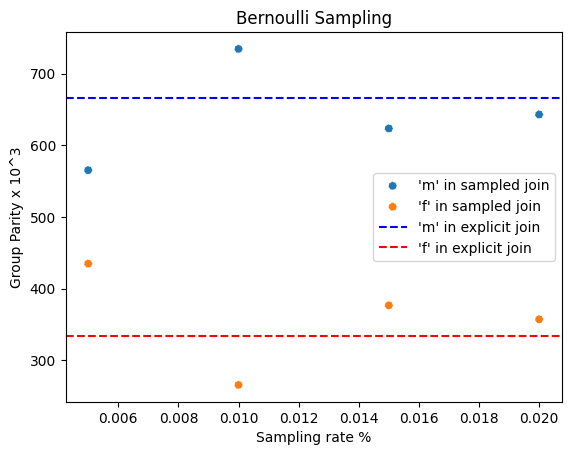

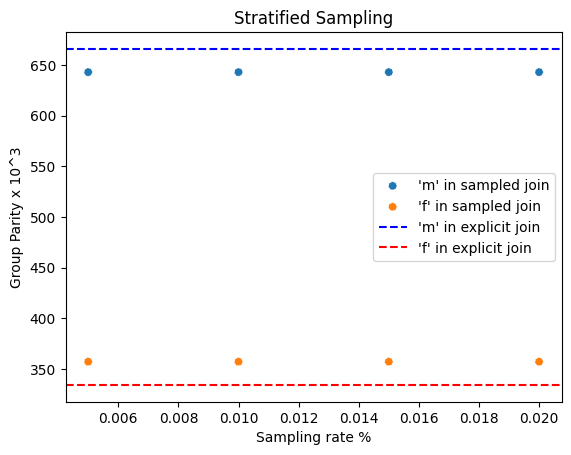

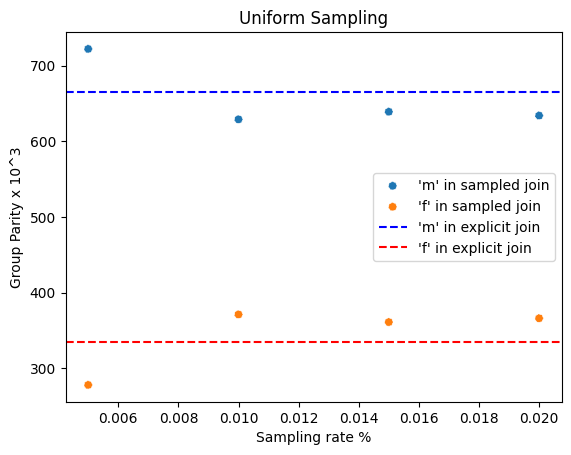

In [131]:
for technique in SAMPLING_TECHNIQUES:
    save_parity_plot(join_dict_norm, sampled_join_dict_norm[technique], technique)

In [1]:
# T is a list of dataframes
# T[i].Fk is the foreign key
# psuedocode for algorithm in chapter 4

def get_db_join_result(T_sample, fk_sample):
    pass

def correlation_aware_sample(fk_set,e):
    return fk_set.sample()

def is_fair_join(RQ, e):
    S = RQ.S # Sensitive attribute
    n = len(RQ)
    groups, group_counts = np.unique(S, return_counts=True) # unique groups
    group_parity = [c/n for c in group_counts] 
    return min(group_parity)/max(group_parity) >= e

def fairness_aware_approx_joins(T: list, e) -> bool:
    if len(T) == 0:
        return None
    fk_set = T[0].Fk  # initialize with first table's foreign key
    for Ti in T:
        fk_set = fk_set.intersection(Ti.Fk)
        
    fk_sample = correlation_aware_sample(fk_set, frac, e)

    # fk_sample = sample(fk_set, frac, e)
    T_sample = [Ti[fk_sample.index] for Ti in T]
    RQ = get_db_join_result(T_sample, fk_sample)
    return is_fair_join(RQ, e)

    


In [18]:
name_cast_df = pd.merge(name, cast_info_df, left_on='id', right_on='id', how='inner')
name_cast_df.head()

,id,name,imdb_index,imdb_id,gender,name_pcode_cf,name_pcode_nf,surname_pcode,md5sum,person_id,movie_id,person_role_id,note,nr_order,role_id
0,3343,"Abela, Mike",None,None,m,A1452,M214,A14,61f733c0298a7cb5a461fd787a655d70,750,405526,789.0,None,10.0,1
1,446,"A., David",None,None,m,A313,D13,A,cf45e7b42fbc800c61462988ad1156d2,159,2214104,NaN,None,NaN,1
2,126,"-Alverio, Esteban Rodriguez",None,None,m,A4162,E2315,A416,f5c410bff6839b545d04c531f776e8f2,31,1484917,1.0,None,NaN,1
3,1678,"Abbas, Athar",None,None,m,A1236,A3612,A12,cf230f6ed718a330dc688c20b8d741d3,471,849284,1.0,(archive footage),NaN,1
4,3610,"Aberer, Leo",None,None,m,A164,L16,A16,05684f16b84db387e613d3de57eca5b7,771,166286,889.0,None,10.0,1
